In [1]:
import platform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from mlxtend.data import loadlocal_mnist

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda

In [2]:
if platform.system() == 'Windows':
    X_train, y_train = loadlocal_mnist(images_path='./MNIST/train-images.idx3-ubyte',
                                       labels_path='./MNIST/train-labels.idx1-ubyte')
    X_test, y_test = loadlocal_mnist(images_path='./MNIST/train-images.idx3-ubyte',
                                     labels_path='./MNIST/train-labels.idx1-ubyte')

In [3]:
X_train.shape

(60000, 784)

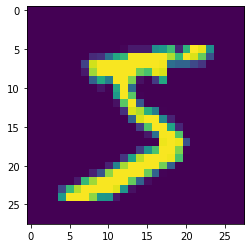

In [4]:
plt.imshow(X_train[0].reshape(28,28))

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(28*28, 128, bias = False)
        self.l2 = nn.Linear(128, 10, bias = False)
        self.sm = nn.LogSoftmax(dim = 1)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)

        return x

In [6]:
cuda.is_available()

True

In [7]:
if cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [8]:
BATCH_SIZE = 128
EPOCHS = 3

In [9]:
model = Net()
model = model.to(device)

"""
with torch.no_grad():
  model.l1.weight.copy_(torch.tensor(layer_init(784, 128).T))
  model.l2.weight.copy_(torch.tensor(layer_init(128, 10).T))
"""

loss_function = nn.NLLLoss(reduction = 'none')
optim = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0)
losses, accuracies = [], []
for epcoh in range(EPOCHS):
    for i in (t := trange(0, 5000)):
        start_ind = i
        end_ind = i + BATCH_SIZE

        # permute random sample
        sample = np.random.randint(0, X_train.shape[0], size = (BATCH_SIZE))
        batch_X = torch.tensor(X_train[sample].reshape((-1, 28*28))).float()
        batch_y = torch.tensor(y_train[sample]).long()

        # send to gpu
        batch_X = batch_X.to(device)

        model.zero_grad()
        output = model(batch_X)

        # send to cpu
        output = output.to('cpu')

        # output label
        label = torch.argmax(output, dim = 1)
        accuracy = (label == batch_y).float().mean()
        loss = loss_function(output, batch_y)
        loss = loss.mean()
        loss.backward()
        optim.step()
        loss, accuracy = loss.item(), accuracy.item()
        losses.append(loss)
        accuracies.append(accuracy)
        t.set_description("loss {:2.2f} accuracy {:2.2f}".format(loss, accuracy))

loss 0.02 accuracy 0.99: 100%|████████████████████████████████████████████████████| 5000/5000 [00:12<00:00, 400.34it/s]


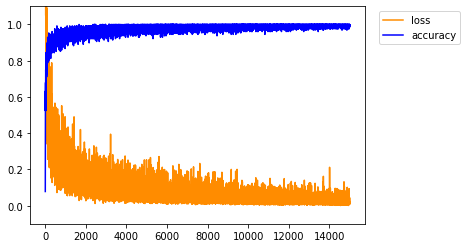

In [10]:
plt.ylim(-0.1, 1.1)
plt.plot(losses, color = 'darkorange', label = 'loss')
plt.plot(accuracies, color = 'blue', label = 'accuracy')
plt.legend(bbox_to_anchor = (1.3,1.))
plt.show()

In [11]:
torch.cuda.empty_cache()

In [20]:
# evaluation
X_test = torch.tensor(X_test).reshape((-1, 28*28)).float()
X_test = X_test.to(device)
Y_test_preds = torch.argmax(model(X_test), dim=1)
Y_test_preds = Y_test_preds.to('cpu').numpy()
(y_test == Y_test_preds).mean()

<ipython-input-20-5c6dc1c8d8a3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).reshape((-1, 28*28)).float()


0.9939833333333333

### For remainder of this, do on cpu for simplicity

In [26]:
model = model.to('cpu')
X_test = X_test.to('cpu')

In [32]:
# compute gradients in torch
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()

<ipython-input-32-7e6ced29e731>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())


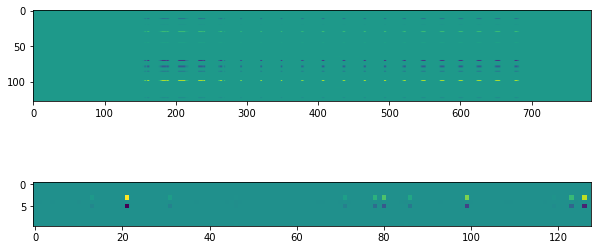

In [31]:
fig, ax = plt.subplots(2,1,figsize = (10,5))
ax[0].imshow(model.l1.weight.grad)
ax[1].imshow(model.l2.weight.grad)
plt.show()

In [ ]:
|